# Example Notebook

Welcome to the example notebook for the Home Credit Kaggle competition. The goal of this competition is to determine how likely a customer is going to default on an issued loan. The main difference between the [first](https://www.kaggle.com/c/home-credit-default-risk) and this competition is that now your submission will be scored with a custom metric that will take into account how well the model performs in future. A decline in performance will be penalized. The goal is to create a model that is stable and performs well in the future.

In this notebook you will see how to:
* Load the data
* Join tables with Polars - a DataFrame library implemented in Rust language, designed to be blazingy fast and memory efficient.  
* Create simple aggregation features
* Train a LightGBM model
* Create a submission table

## Load the data

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 

dataPath = "./home-credit-credit-risk-model-stability/"

In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [3]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [4]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

## Feature engineering

In this part, we can see a simple example of joining tables via `case_id`. Here the loading and joining is done with polars library. Polars library is blazingly fast and has much smaller memory footprint than pandas. 

In [5]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [6]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [7]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.8, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [8]:
print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (1221327, 48)
Test: (305332, 48)


In [9]:
X_train.to_pickle('X_train.pkl')
y_train.to_pickle('y_train.pkl')

X_test.to_pickle('X_test.pkl')
y_test.to_pickle('y_test.pkl')

# Data Exploration and Cleaning

In [11]:
feature_definitions = pd.read_csv(dataPath + "feature_definitions.csv")
feature_definitions

,Variable,Description
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...
1,actualdpdtolerance_344P,DPD of client with tolerance.
2,addres_district_368M,District of the person's address.
3,addres_role_871L,Role of person's address.
4,addres_zip_823M,Zip code of the address.
...,...,...
460,totinstallast1m_4525188A,Total amount of monthly instalments paid in th...
461,twobodfilling_608L,Type of application process.
462,type_25L,Contact type of a person.
463,typesuite_864L,Persons accompanying the client during the loa...


In [10]:
X_train

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,NaN,1917.6000,0.0,NaN,NaN,NaN,NaN,30000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3134.0000,0.0,NaN,NaN,NaN,NaN,19999.8,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4937.0000,0.0,NaN,NaN,NaN,NaN,78000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3600.0000,0.0,NaN,NaN,NaN,NaN,60000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3110.8000,0.0,NaN,NaN,NaN,NaN,20000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221322,176561.36,3675.4001,0.0,7356.8003,NaN,16392.496,6750.2,30000.0,0.0,0.0,...,14346.319,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,NaN,NaN,12155.0,NaN
1221323,301276.47,7088.6000,6191.6,12553.2000,NaN,105129.310,15780.4,100000.0,68098.4,68098.4,...,40499.805,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,NaN,NaN,22904.6,NaN
1221324,14232.40,7788.8003,0.0,2662.4001,NaN,NaN,1500.6,60000.0,0.0,0.0,...,NaN,2fc785b2,a55475b1,a55475b1,a55475b1,a55475b1,NaN,NaN,NaN,NaN
1221325,197371.58,1195.4000,2827.2,8212.6010,NaN,47943.062,9921.2,6000.0,46806.6,46806.6,...,5654.400,2fc785b2,6b2ae0fa,a55475b1,3439d993,a55475b1,NaN,NaN,15792.4,NaN


In [12]:
y_train

0          0
1          0
2          0
3          0
4          0
          ..
1221322    0
1221323    0
1221324    0
1221325    0
1221326    0
Name: target, Length: 1221327, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221327 entries, 0 to 1221326
Data columns (total 48 columns):
 #   Column                           Non-Null Count    Dtype   
---  ------                           --------------    -----   
 0   amtinstpaidbefduel24m_4187115A   772284 non-null   float64 
 1   annuity_780A                     1221327 non-null  float64 
 2   annuitynextmonth_57A             1221325 non-null  float64 
 3   avginstallast24m_3658937A        721281 non-null   float64 
 4   avglnamtstart24m_4525187A        130134 non-null   float64 
 5   avgoutstandbalancel6m_4187114A   548369 non-null   float64 
 6   avgpmtlast12m_4525200A           399494 non-null   float64 
 7   credamount_770A                  1221327 non-null  float64 
 8   currdebt_22A                     1221325 non-null  float64 
 9   currdebtcredtyperange_828A       1221325 non-null  float64 
 10  disbursedcredamount_1113A        1221327 non-null  float64 
 11  downpmt_116A                     1221

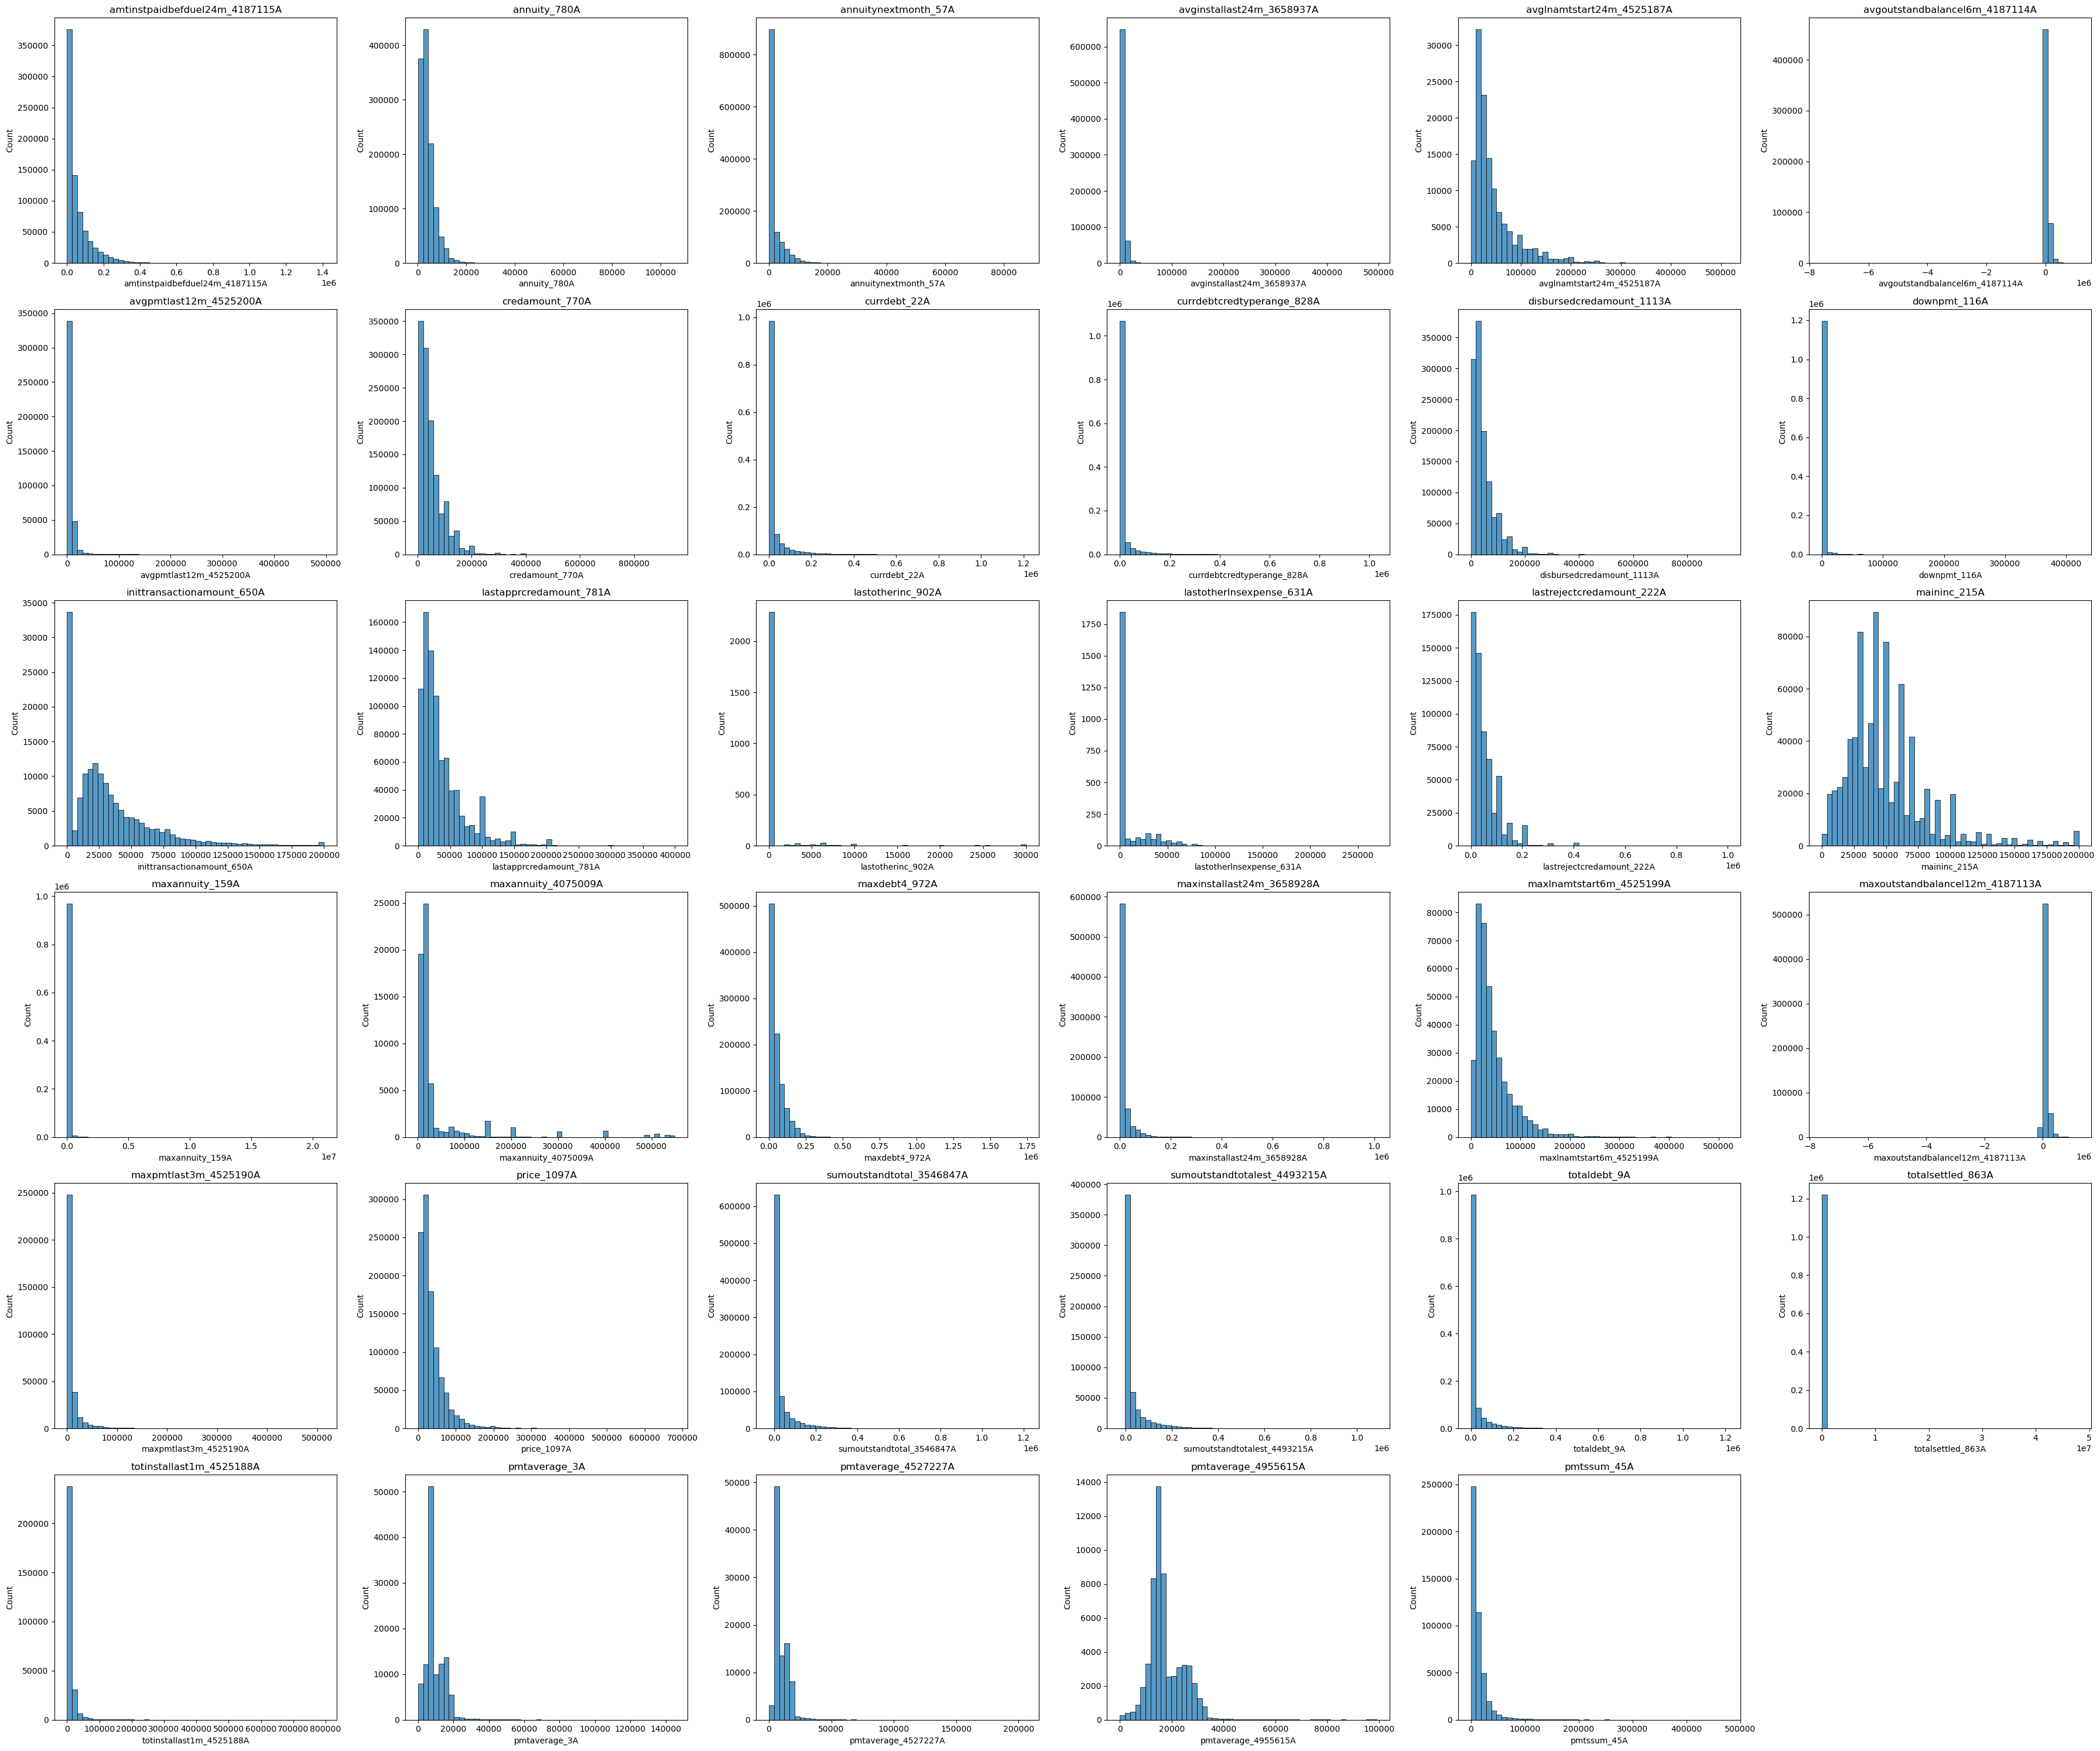

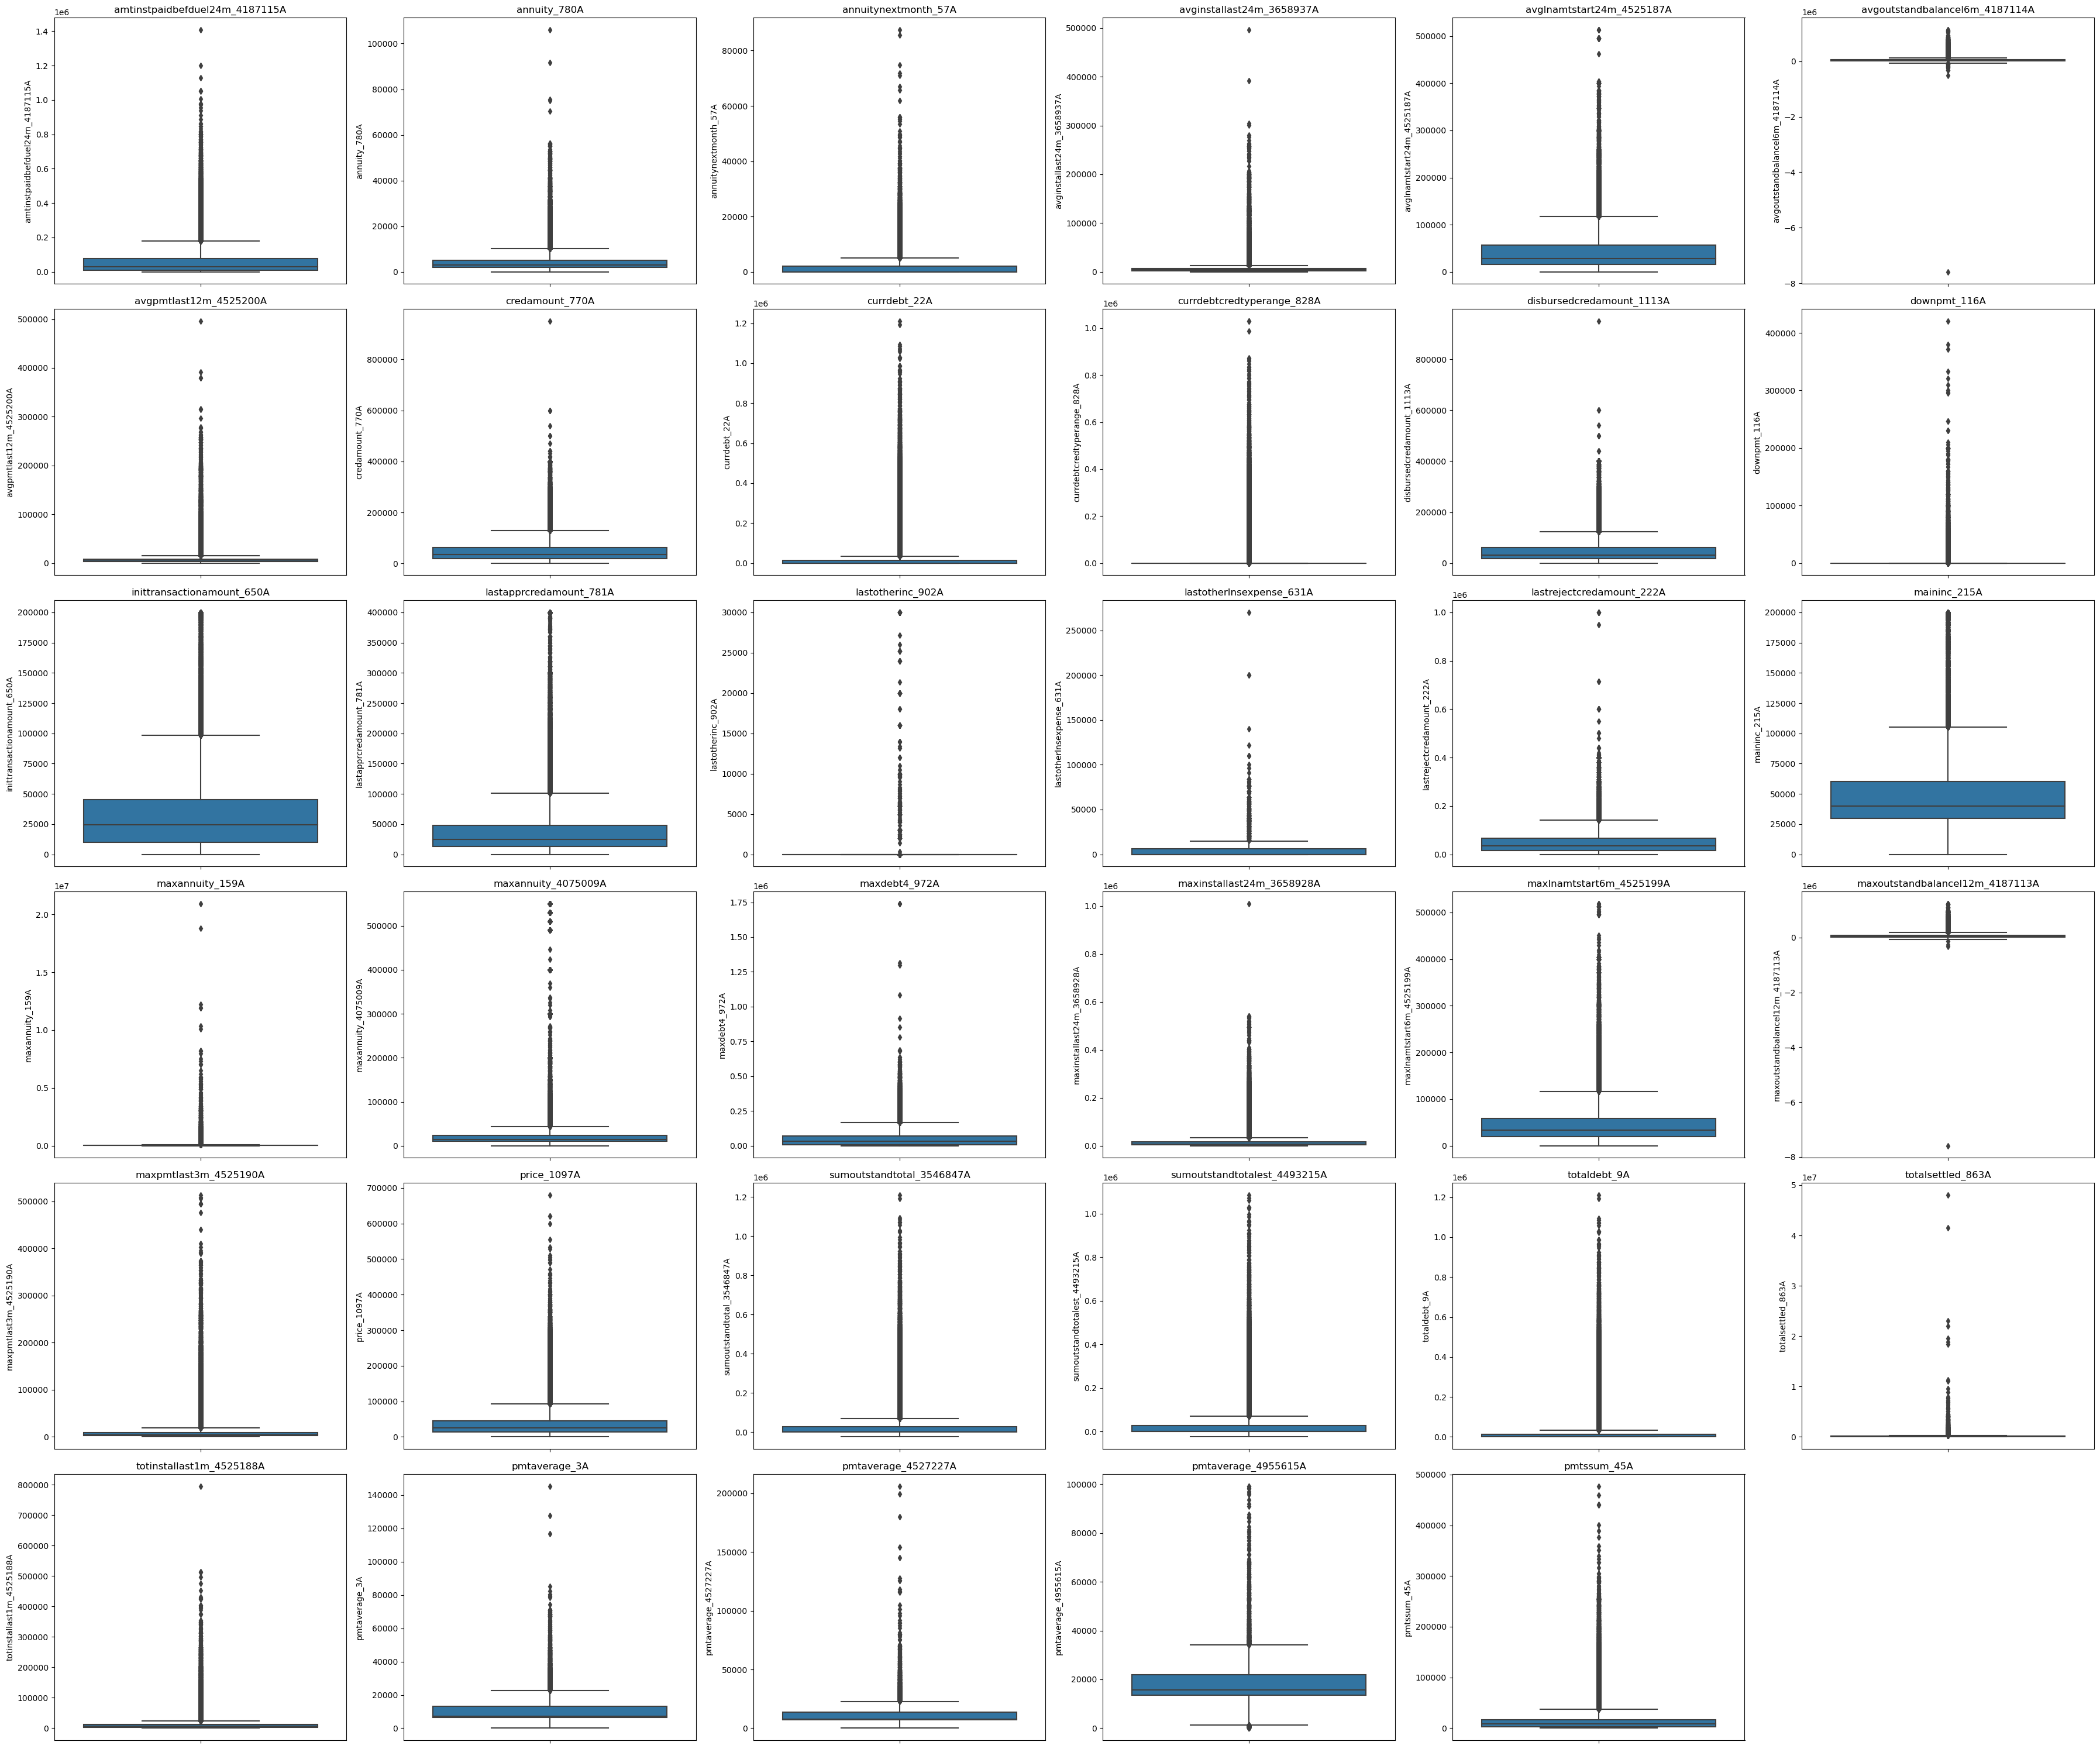

In [22]:
# Basic information
print(X_train.info())

# Descriptive statistics for numerical features
print(X_train.describe())

# Counts of unique values for categorical features
for col in X_train.select_dtypes(include=['object', 'category']).columns:
    print(X_train[col].value_counts())

# Check for missing values
print(X_train.isnull().sum())


# Visualize distributions and potential outliers
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns
num_cols = X_train.select_dtypes(include=['number']).columns

# Determine the number of rows/columns for the grid
n_cols = 6  # Choose the number of columns per row
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # Calculate the number of rows needed

plt.figure(figsize=(n_cols * 6, n_rows * 5))  # Adjust figure size as needed

for i, col in enumerate(num_cols, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X_train[col], bins=50, kde=False)
    plt.title(col)

plt.tight_layout()
plt.show()


plt.figure(figsize=(n_cols * 6, n_rows * 5))  # Adjust figure size as needed

for i, col in enumerate(num_cols, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=X_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()


## Missing Values - to drop or not to drop?

Deciding Which Rows to Drop: Deciding which rows with missing data to drop rather than impute depends on several factors:
If a row has a high percentage of its features missing, it may not provide enough information for accurate predictions.
If missing values are not random (Missing Not at Random - MNAR) and represent a pattern, dropping these rows may introduce bias.
Critical features for prediction that are missing in a row may warrant the row being dropped if imputation would introduce high uncertainty.

/var/folders/3z/7fcw3rc512d4pscjrc0tq66w0000gn/T/ipykernel_23519/3311689907.py:10: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = X_train.corrwith(y_train)


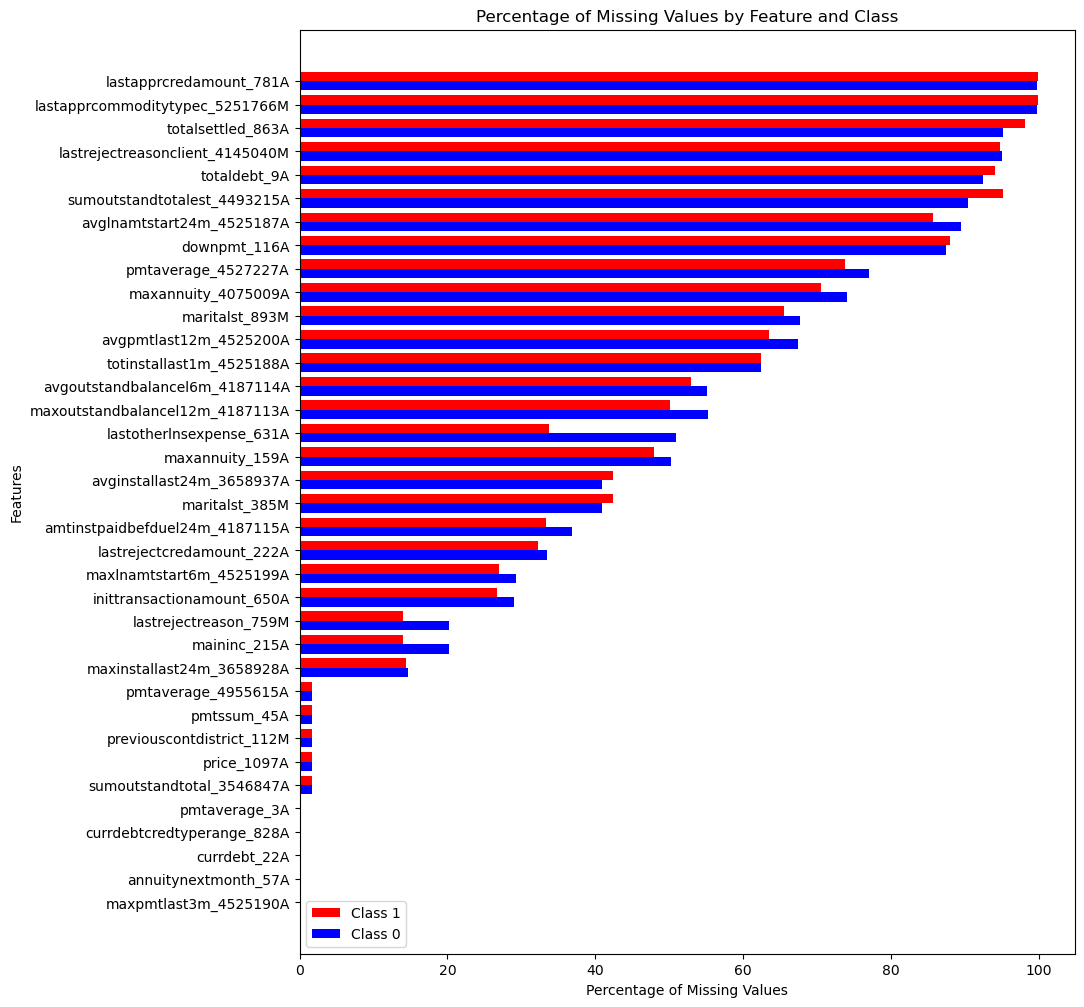

,CorrelationWithTarget,PercentageMissing,Class 1 Missing,Class 0 Missing,Description
lastapprcredamount_781A,0.007727,99.797515,99.835728,99.796277,Credit amount from the client's last application.
lastapprcommoditytypec_5251766M,NaN,99.797188,99.825298,99.796277,Commodity type of the last application.
totalsettled_863A,0.019517,95.294053,98.117389,95.202523,Sum of all payments made by the client.
lastrejectreasonclient_4145040M,NaN,95.037447,94.753722,95.046645,Reason for the client's last loan rejection.
totaldebt_9A,0.021313,92.478755,94.036661,92.428249,Total amount of debt.
sumoutstandtotalest_4493215A,0.026832,90.603827,95.090089,90.458386,Sum of total outstanding amount.
avglnamtstart24m_4525187A,0.028709,89.344868,85.726578,89.462170,Average loan amount in the last 24 months.
downpmt_116A,0.005942,87.402800,87.982060,87.384021,Amount of downpayment.
pmtaverage_4527227A,0.054811,76.926818,73.721676,77.030726,Average of tax deductions.
maxannuity_4075009A,0.007103,73.988866,70.597898,74.098798,Maximal annuity offered to the client in the c...


In [153]:
# Assuming X_train is your features DataFrame, y_train is your target Series, and feature_definitions is your feature descriptions DataFrame

# Calculate the percentage of missing values for each feature overall and within each class
total_missing = X_train.isnull().mean() * 100
class_1_missing = X_train[y_train == 1].isnull().mean() * 100
class_0_missing = X_train[y_train == 0].isnull().mean() * 100

# Create a DataFrame with the correlation and missing values information

correlations = X_train.corrwith(y_train)

correlation_and_missing_df = pd.DataFrame({
    'CorrelationWithTarget': np.abs(correlations),
    'PercentageMissing': total_missing.values,
    'Class 1 Missing': class_1_missing.values,
    'Class 0 Missing': class_0_missing.values,
    'Description': feature_definitions.set_index('Variable').loc[total_missing.index, 'Description']
})

# Filter out features with X% or more missing values
correlation_and_missing_df = correlation_and_missing_df[correlation_and_missing_df['PercentageMissing'] > 0]


# Sort the DataFrame by the total missing values to maintain the order for plotting
correlation_and_missing_df.sort_values(by='PercentageMissing', ascending=False, inplace=True)

# Plotting the missing values by class, with horizontal bars
fig, ax = plt.subplots(figsize=(10, 12))
ind = np.arange(len(correlation_and_missing_df))  # the x locations for the groups
width = 0.4  # the width of the bars

p1 = ax.barh(ind, correlation_and_missing_df['Class 1 Missing'], width, color='red', label='Class 1')
p2 = ax.barh(ind + width, correlation_and_missing_df['Class 0 Missing'], width, color='blue', label='Class 0')

ax.set_title('Percentage of Missing Values by Feature and Class')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(correlation_and_missing_df.index)
ax.legend()

plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')

# Inverting y-axis to have the feature with most missing values on top
plt.gca().invert_yaxis()

plt.show()

correlation_and_missing_df

In [161]:
df_a = pd.DataFrame(correlation_and_missing_df)
df_a['index'] = df_a.index
df_b = pd.DataFrame(feature_definitions)

# Extract prefixes excluding the last part from dataframe A index values
df_a['Prefix'] = df_a['index'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Extract prefixes from dataframe B Variable values
df_b['Prefix'] = df_b['Variable'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Group variables by their prefix
grouped_variables = df_b.groupby('Prefix')['Variable'].apply(list)

# Find matches for each variable
for index, row in df_a.iterrows():
    prefix = row['Prefix']
    if prefix in grouped_variables and len(grouped_variables[prefix]) > 1:
        print(f"Index: {row['index']}, Matches: {grouped_variables[prefix]}")

Index: downpmt_116A, Matches: ['downpmt_116A', 'downpmt_134A']
Index: pmtaverage_4527227A, Matches: ['pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A']
Index: maxannuity_4075009A, Matches: ['maxannuity_159A', 'maxannuity_4075009A']
Index: maritalst_893M, Matches: ['maritalst_385M', 'maritalst_703L', 'maritalst_893M']
Index: maxannuity_159A, Matches: ['maxannuity_159A', 'maxannuity_4075009A']
Index: maritalst_385M, Matches: ['maritalst_385M', 'maritalst_703L', 'maritalst_893M']
Index: pmtaverage_4955615A, Matches: ['pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A']
Index: pmtaverage_3A, Matches: ['pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A']
Index: currdebt_22A, Matches: ['currdebt_22A', 'currdebt_94A']


In [157]:
matching_variables['Variable']

14      amtinstpaidbefduel24m_4187115A
19                annuitynextmonth_57A
34           avginstallast24m_3658937A
35           avglnamtstart24m_4525187A
37      avgoutstandbalancel6m_4187114A
38              avgpmtlast12m_4525200A
112                       currdebt_22A
113                       currdebt_94A
114         currdebtcredtyperange_828A
143                       downpmt_116A
144                       downpmt_134A
206         inittransactionamount_650A
232    lastapprcommoditytypec_5251766M
233            lastapprcredamount_781A
239           lastotherlnsexpense_631A
242          lastrejectcredamount_222A
244              lastrejectreason_759M
245    lastrejectreasonclient_4145040M
251                       maininc_215A
254                     maritalst_385M
255                     maritalst_703L
256                     maritalst_893M
259                    maxannuity_159A
260                maxannuity_4075009A
276          maxinstallast24m_3658928A
277           maxlnamtsta

/var/folders/3z/7fcw3rc512d4pscjrc0tq66w0000gn/T/ipykernel_23519/3338660479.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = X_with_target.corr()


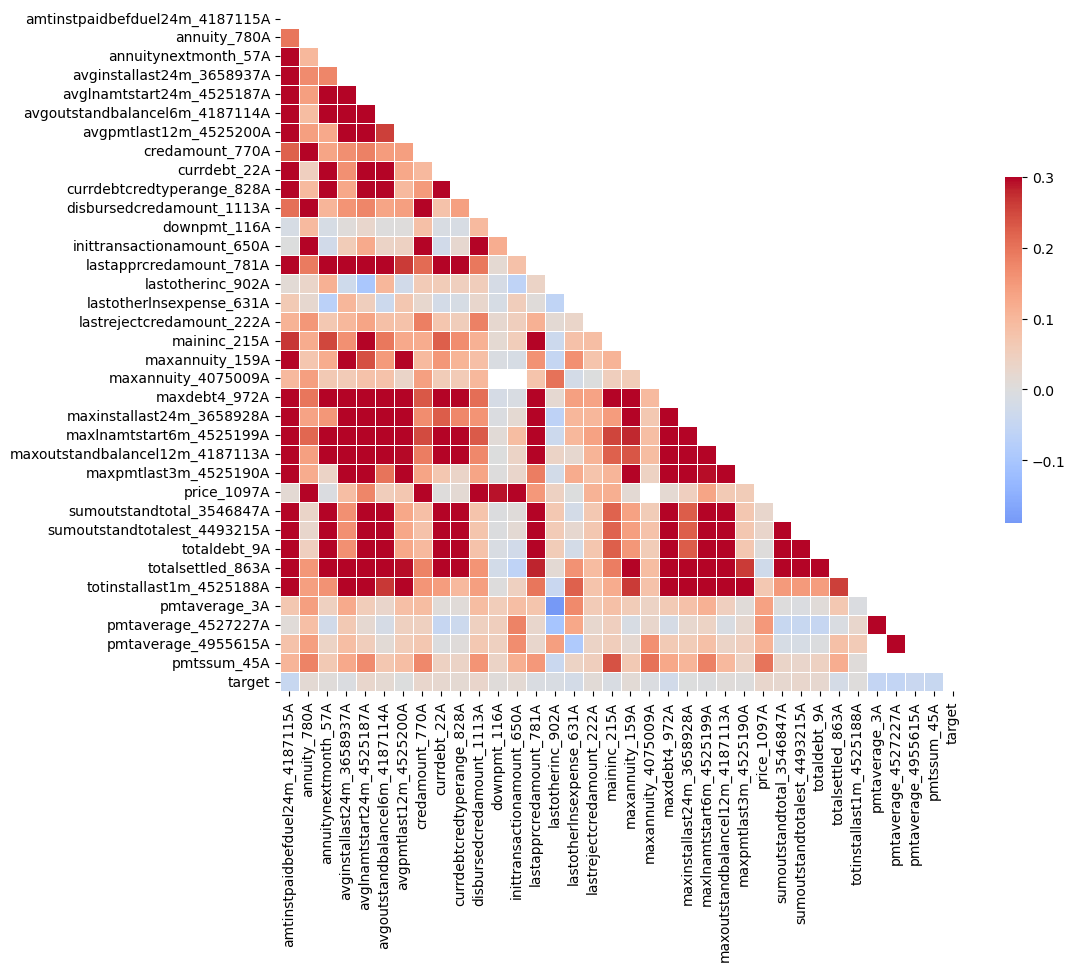

In [44]:
# Assume X_train is your dataframe and y_train is the series with the target variable
X_with_target = X_train.copy()
X_with_target['target'] = y_train  # Add the target variable to the dataframe

# Compute the correlation matrix
corr = X_with_target.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


Identify features with 50% or more missing values for each class in y_train.
Calculate the correlation of these features with the default.
Decide to drop or keep the features based on the correlation strength.

# Data Cleaning 

In [12]:
# only use 20 per cent of the training data
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=1)

### Standardize and Impute Missing Values (Numerical Features)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Preprocessing steps for numerical data
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with the median
    ('scaler', StandardScaler())  # Standardize features by removing the mean and scaling to unit variance
])

### Hot Encoding

In [23]:
from sklearn.preprocessing import OneHotEncoder

# Preprocessing steps for categorical data
categorical_preprocessor = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent category
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Apply one-hot encoding
])

In [24]:
from sklearn.compose import ColumnTransformer

categorical_columns = X_train_small.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = [col for col in X_train_small.columns if col not in categorical_columns]

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_columns),
        ('cat', categorical_preprocessor, categorical_columns)
    ])

# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train_small)

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)


# Retrieve new column names for one-hot encoded categorical features
# Note: Adjust 'cat' to the name you used for the categorical transformer in your ColumnTransformer
new_categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out()

# The numerical features' names remain the same, so we just reuse the numerical_columns list
new_column_names = list(numerical_columns) + list(new_categorical_features)

# Create a new DataFrame for the transformed training data
X_train_df = pd.DataFrame(X_train_transformed, columns=new_column_names, index=X_train_small.index)

# Create a new DataFrame for the transformed test data
X_test_df = pd.DataFrame(X_test_transformed, columns=new_column_names, index=X_test.index)


In [16]:
X_train_df.head()

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,maritalst_385M_b6cabe76,maritalst_385M_ecd83604,maritalst_385M_nan,maritalst_893M_1a19667c,maritalst_893M_46b968c3,maritalst_893M_977b2a70,maritalst_893M_a55475b1,maritalst_893M_e18430ff,maritalst_893M_ecd83604,maritalst_893M_nan
1012115,-0.113253,1.502627,-0.510494,0.346896,-0.777285,-0.535705,0.242811,0.716672,-0.385964,-0.298523,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
784681,-0.272135,0.543070,-0.510494,-0.206609,-0.111512,-0.237345,-0.005239,0.411967,-0.385964,-0.298523,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
842788,-0.676898,-0.186588,0.495066,2.613447,0.247569,-0.419050,2.408172,-0.274243,0.299270,0.466001,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
817383,-0.438635,-0.703411,-0.510494,-0.584557,-0.111512,-0.652275,-0.588562,-0.606624,-0.385964,-0.298523,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
398184,-0.663636,-0.816866,0.170712,-0.579645,1.028368,0.203793,-0.583959,-0.776969,0.357131,-0.298523,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## PCA

In [14]:
from sklearn.decomposition import PCA

# Add PCA to the preprocessing pipeline
pca = PCA(n_components=0.95)  # Retain 95% of the variance
preprocessor_with_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Includes the previous preprocessing steps
    ('pca', pca)
])

# Fit and transform the training data with PCA
X_train_transformed_with_pca = preprocessor_with_pca.fit_transform(X_train_small)

# Transform the test data with PCA
X_test_transformed_with_pca = preprocessor_with_pca.transform(X_test)

# Create new column names for the transformed features with PCA
new_column_names_with_pca = [f'PC_{i+1}' for i in range(X_train_transformed_with_pca.shape[1])]

# Create a new DataFrame for the transformed training data with PCA
X_train_df_with_pca = pd.DataFrame(X_train_transformed_with_pca, columns=new_column_names_with_pca, index=X_train_small.index)

# Create a new DataFrame for the transformed test data with PCA
X_test_df_with_pca = pd.DataFrame(X_test_transformed_with_pca, columns=new_column_names_with_pca, index=X_test.index)


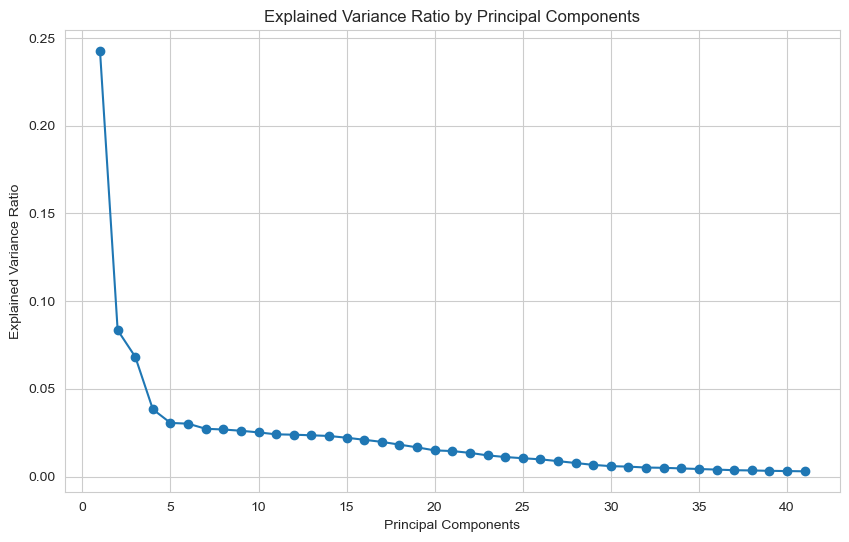

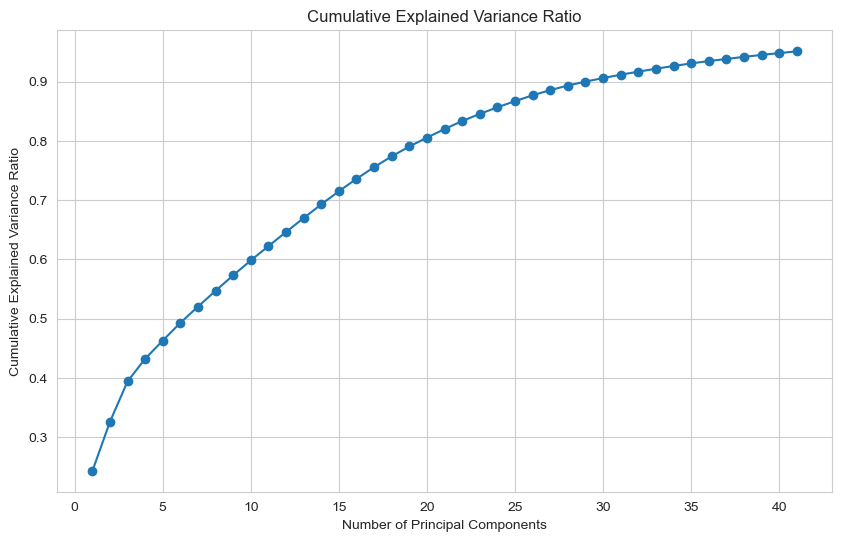

In [15]:
import matplotlib.pyplot as plt

# Fit PCA on the training data
pca.fit(X_train_transformed)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


# Prediction

In [25]:
X_train_df.to_csv('X_train_df.csv')
y_train_small.to_csv('y_train.csv')


KeyboardInterrupt



## Transform the test data

In [16]:
# already transformed before, but it should happen here

## Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=0, class_weight='balanced')

# Fit the model on the training data
decision_tree_model.fit(X_train_df, y_train_small)

# Predict on the test data
y_pred_dt = decision_tree_model.predict(X_test_df)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9305411814025388
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    295689
           1       0.06      0.09      0.07      9643

    accuracy                           0.93    305332
   macro avg       0.52      0.52      0.52    305332
weighted avg       0.94      0.93      0.94    305332


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=0, class_weight='balanced')

# Fit the model on the training data
decision_tree_model.fit(X_train_df_with_pca, y_train_small)

# Predict on the test data
y_pred_dt = decision_tree_model.predict(X_test_df_with_pca)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

KeyboardInterrupt: 

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logistic_regression_model = LogisticRegression(random_state=0, max_iter=300, class_weight='balanced')

# Fit the model on the training data
logistic_regression_model.fit(X_train_df, y_train_small)

# Predict on the test data
y_pred_lr = logistic_regression_model.predict(X_test_df)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


/Users/filipp/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6880936161293281
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    295689
           1       0.06      0.61      0.11      9643

    accuracy                           0.69    305332
   macro avg       0.52      0.65      0.46    305332
weighted avg       0.95      0.69      0.79    305332


In [23]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(logistic_regression_model, X_test_df, y_test, n_repeats=10, random_state=0, n_jobs=-1)

# Extract and print the importance of features
importance_df = pd.DataFrame({'feature':X_test_df.columns, 'importance':result.importances_mean}).sort_values(by='importance', ascending=False)
print(importance_df.head())

KeyboardInterrupt: 

In [36]:
# Initialize the Logistic Regression model
logistic_regression_model = LogisticRegression(random_state=0, max_iter=900, class_weight='balanced')

# Fit the model on the training data
logistic_regression_model.fit(X_train_df_with_pca, y_train_small)

# Predict on the test data
y_pred_lr = logistic_regression_model.predict(X_test_df_with_pca)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.672933069576723
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80    295689
           1       0.06      0.62      0.11      9643

    accuracy                           0.67    305332
   macro avg       0.52      0.65      0.45    305332
weighted avg       0.95      0.67      0.78    305332


## kNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the kNN Classifier model
# 'n_neighbors' is set to 5 as a starting point
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn_model.fit(X_train_df_with_pca, y_train_small)

# Predict on the test data
y_pred_knn = knn_model.predict(X_test_df_with_pca)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"kNN Classifier Accuracy: {accuracy_knn}")
print("kNN Classifier Classification Report:")
print(classification_report(y_test, y_pred_knn))


kNN Classifier Accuracy: 0.9676974571941362
kNN Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295689
           1       0.15      0.01      0.01      9643

    accuracy                           0.97    305332
   macro avg       0.56      0.50      0.50    305332
weighted avg       0.94      0.97      0.95    305332


## Neural Network

In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30),  # Example: one hidden layer with 100 neurons
                    activation='relu',  # Activation function for the hidden layer
                    solver='adam',  # Solver for weight optimization
                    max_iter=500,  # Maximum number of epochs
                    random_state=1,  # Seed for random number generator for reproducibility
                    learning_rate_init=0.001,
                    tol=0.000001,
                    verbose=True,
                    batch_size='auto',  # 'auto' means the batch size is min(200, n_samples)
                    ) 


mlp.fit(X_train_df_with_pca, y_train_small)

y_pred = mlp.predict(X_test_df_with_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

# Detailed classification report
print(classification_report(y_test, y_pred))

Iteration 1, loss = 0.13595838
Iteration 2, loss = 0.13023111
Iteration 3, loss = 0.12954982
Iteration 4, loss = 0.12903601
Iteration 5, loss = 0.12869768
Iteration 6, loss = 0.12846927
Iteration 7, loss = 0.12816368
Iteration 8, loss = 0.12800412
Iteration 9, loss = 0.12779660
Iteration 10, loss = 0.12765097
Iteration 11, loss = 0.12746676
Iteration 12, loss = 0.12727708
Iteration 13, loss = 0.12714373
Iteration 14, loss = 0.12703235
Iteration 15, loss = 0.12684874
Iteration 16, loss = 0.12675988
Iteration 17, loss = 0.12668547
Iteration 18, loss = 0.12657739
Iteration 19, loss = 0.12651088
Iteration 20, loss = 0.12630921
Iteration 21, loss = 0.12622980
Iteration 22, loss = 0.12621965
Iteration 23, loss = 0.12607687
Iteration 24, loss = 0.12601764
Iteration 25, loss = 0.12593606
Iteration 26, loss = 0.12583596
Iteration 27, loss = 0.12576517
Iteration 28, loss = 0.12575168
Iteration 29, loss = 0.12558827
Iteration 30, loss = 0.12555067
Iteration 31, loss = 0.12547806
Iteration 32, los

In [51]:
print(classification_report(y_train_small, mlp.predict(X_train_df_with_pca)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    473114
           1       0.64      0.01      0.01     15416

    accuracy                           0.97    488530
   macro avg       0.81      0.50      0.50    488530
weighted avg       0.96      0.97      0.95    488530


## Training LightGBM

Minimal example of LightGBM training is shown below.

In [ ]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/Users/filipp/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Evaluation with AUC and then comparison with the stability metric is shown below.

In [1]:
for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')  

NameError: name 'base_train' is not defined

In [2]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(base_train)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the test set is: {stability_score_test}')  

NameError: name 'base_train' is not defined

## Submission

Scoring the submission dataset is below, we need to take care of new categories. Then we save the score as a last step. 

In [ ]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

y_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration)

In [ ]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")

Best of luck, and most importantly, enjoy the process of learning and discovery! 

<img src="https://i.imgur.com/obVWIBh.png" alt="Image" width="700"/>